In [1]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [2]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test[:10%]"])

In [3]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [4]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [5]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [6]:
train_dataset[200]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369>},
   {'type': 'text',
    'text': 'Is the rightmost value of light brown graph 58?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]

In [7]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-500M-Instruct"

In [8]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [9]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text',
    'text': 'How many values are below 40 in Unfavorable graph?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '6'}]}]

In [10]:
train_dataset[1][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text',
    'text': 'How many values are below 40 in Unfavorable graph?'}]}]

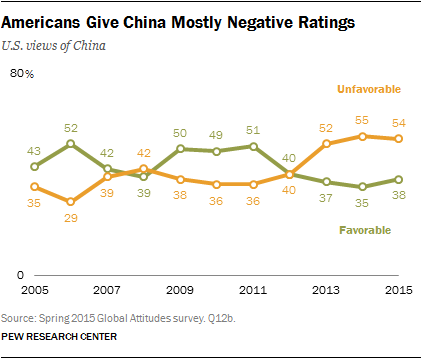

In [11]:
train_dataset[1][1]["content"][0]["image"]

In [12]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], add_generation_prompt=True  # Use the sample without the system message
    )

    image_inputs = []
    image = sample[1]["content"][0]["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        # text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [13]:
output = generate_text_from_sample(model, processor, train_dataset[1])
output

' The U.S. public’s views of China have been mixed in recent years. In 2015, 54% gave China a favorable rating, while 38% gave it an unfavorable rating.'

In [14]:
import gc
import time

In [15]:
def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")




In [16]:
clear_memory()


GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


# Fine-Tune the Model using TRL
## 4.1 Load the Quantized Model for Training ⚙️

Next, we’ll load the quantized model using bitsandbytes. If you want to learn more about quantization, check out this blog post or this one.

In [17]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


## 4.2 Set Up QLoRA and SFTConfig 🚀
Next, we’ll configure QLoRA for our training setup. QLoRA allows efficient fine-tuning of large models by reducing the memory footprint. Unlike traditional LoRA, which uses low-rank approximation, QLoRA further quantizes the LoRA adapter weights, leading to even lower memory usage and faster training.

To boost efficiency, we can also leverage a paged optimizer or 8-bit optimizer during QLoRA implementation. This approach enhances memory efficiency and speeds up computations, making it ideal for optimizing our model without sacrificing performance.

Copied


In [18]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 5,088,256 || all params: 512,570,560 || trainable%: 0.9927


We will use Supervised Fine-Tuning (SFT) to improve our model’s performance on the specific task. To achieve this, we’ll define the training arguments with the SFTConfig class from the TRL library. SFT leverages labeled data to help the model generate more accurate responses, adapting it to the task. This approach enhances the model’s ability to understand and respond to visual queries more effectively.


In [19]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smolvlm-instruct-trl-sft-ChartQA",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

## 4.3 Training the Model 🏃
To ensure that the data is correctly structured for the model during training, we need to define a collator function. This function will handle the formatting and batching of our dataset inputs, ensuring the data is properly aligned for training.

👉 For more details, check out the official TRL example scripts.

In [20]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
    processor.tokenizer.additional_special_tokens.index("<image>")
]


def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
        image = example[1]["content"][0]["image"]
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

Now, we will define the SFTTrainer, which is a wrapper around the transformers.Trainer class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the PeftModel when a PeftConfig object is provided. By using SFTTrainer, we can efficiently manage the training workflow and ensure a smooth fine-tuning experience for our Vision Language Model.


In [21]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

/tmp/ipykernel_14038/93380869.py:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/lv/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
25,3.244000
50,1.884800
75,0.556100
100,0.309300
125,0.267400
150,0.238200


/home/lv/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/lv/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/lv/.local/lib/python3.10/site-packages